In [62]:
library(ape)
library(castor)
library(data.table)
library(ggplot2)
library(ggpubr)


## 1. Pairwise genetic distance

In [40]:
INDIR = "/data2/kantian/LineageTracing/SMALT/0.Results/2.final_phy_re/"
setwd(INDIR)
OUTDIR = "/data2/kantian/LineageTracing/SMALT/0.Results/figures/"
sampleTypes = c("WT_N","IBD_N","IBD_T_Polyclonal","IBD_T_Monoclonal")
samples = list(c("WT1_N5","WT1_N7","WT2_N3","WT2_N5"),
               c("2_N","4_N","5_N","16_N","17_N","19_N","47_N1","47_N4","47_N5","47_N6","47_N8","49_N","50_N","65_N","66_N","142_N","148_N","151_N"),
               c("2_T2","2_T3","17_T4","18_T3","18_T4","19_T1","19_T4","19_T5","47_T1","47_T4","47_T5","47_T6","47_T8","50_T","65_T3","132_T1","142_T2","142_T5-4","148_T3","151_T4"),
               c("4_T","5_T","16_T","19_T3","49_T1","49_T3","65_T1","66_T","142_T1","148_T1")
                  )
dt <- data.table()
for(my.type in 1:length(sampleTypes)){
    # message("Calculating ", sampleTypes[my.type],"...")
    subs <- samples[[my.type]]
    for(my.sample in 1:length(subs)){
        # message("\tCalculating ", subs[my.sample],"...")
        x <- read.delim(paste0(INDIR,subs[my.sample],"_filtered_re.phy"),header = F, sep = " ",
                    colClasses=c("character","character"),skip = 2,
                    col.names = c("cellID","bi"))
        if(nrow(x)>20){
            sampled_pairs <- as.data.frame(t(combn(seq_len(nrow(x)),2)))
            if(nrow(sampled_pairs)<=1000){
                sampled_pairs <- sampled_pairs
            }else{
                sampled_pairs <- sampled_pairs[sample(nrow(sampled_pairs),1000),]
            }
            
            dist <- c()
            for(i in 1:nrow(sampled_pairs)){
                c1 <- strsplit(x$bi[sampled_pairs[i,1]],"")[[1]]
                c2 <- strsplit(x$bi[sampled_pairs[i,2]],"")[[1]]
                dist <- c(dist, 1-length(c1[c1 != c2])/length(unique(c(which(c1 =="1"),which(c2 =="1")))))
            }
            dt <- rbind(dt, data.table(sampleType = sampleTypes[my.type],
                                   sample = subs[my.sample],
                                   dist = dist))   
        }
    }
}
dt[1:3,]

sampleType,sample,dist
<chr>,<chr>,<dbl>
WT_N,WT1_N5,0
WT_N,WT1_N5,0
WT_N,WT1_N5,0


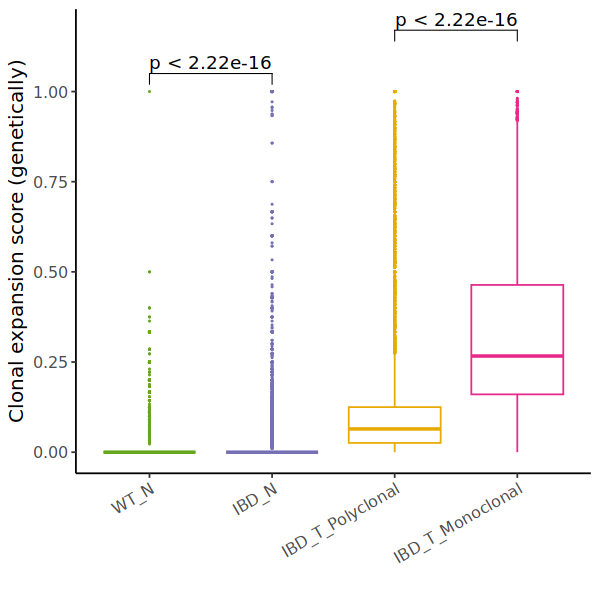

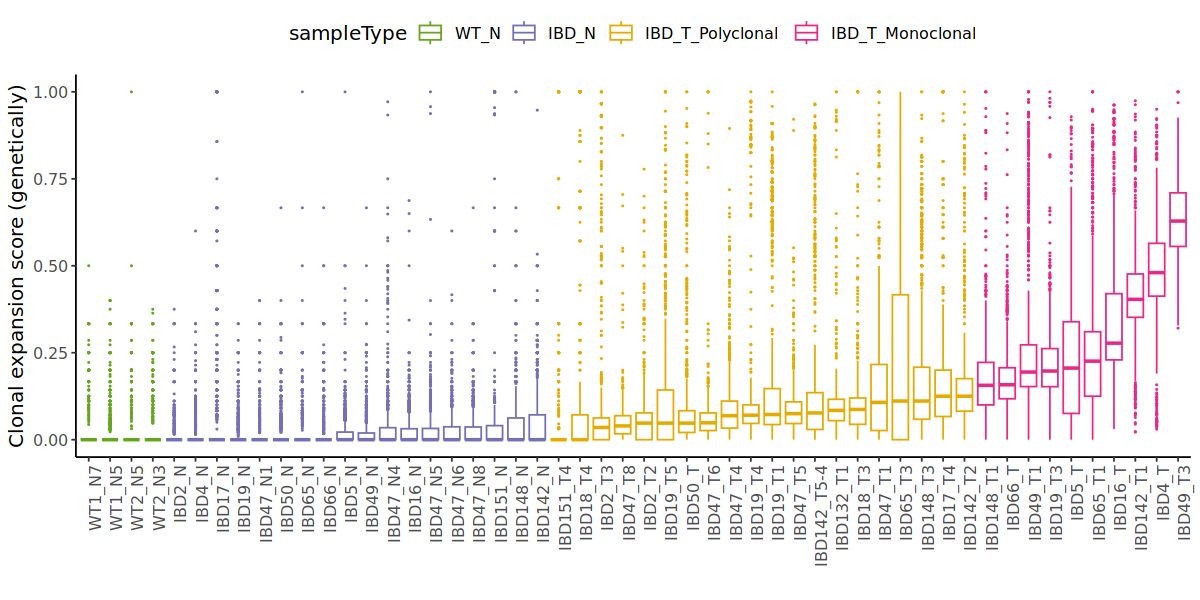

In [49]:
dt[sampleType!="WT_N",sample:=paste0("IBD",sample)]
# dt[,sample:=gsub("IBDIBD","IBD",sample)]
meds <- dt[, median(dist), by=c("sampleType","sample")]
meds <- meds[order(V1)]
preorders <- c('WT1_N7','WT1_N5','WT2_N5','WT2_N3','IBD2_N','IBD4_N','IBD17_N','IBD19_N','IBD47_N1','IBD50_N','IBD65_N','IBD66_N',
               'IBD5_N','IBD49_N','IBD47_N4','IBD16_N','IBD47_N5','IBD47_N6','IBD47_N8','IBD151_N','IBD148_N','IBD142_N','IBD151_T4','IBD18_T4')
dt$sampleType <- factor(dt$sampleType, levels = c("WT_N","IBD_N","IBD_T_Polyclonal","IBD_T_Monoclonal"))
d <- data.table()
for(my.type in sampleTypes){
    temp <- meds[sampleType==my.type]
    d <- rbind(d, temp)
}
# unique(d$sample)
orders <-  unique(d$sample)
orders <- c(preorders, orders[!orders %in% preorders])

dt$sample  <- factor(dt$sample, levels = orders)

##
my_comparisons <- list(c("WT_N","IBD_N"),c("IBD_T_Monoclonal","IBD_T_Polyclonal"))
cols = c("#66A61E","#7570B3","#E6AB02","#E7298A")
# mycols <- c("#D95F02","#E7298A") 

p1 <- ggplot(dt, aes(x=sampleType, y=dist,color=sampleType))+
  geom_boxplot(outlier.size=0.2)+#ggtitle()+
  labs(x="", y="Clonal expansion score (genetically)")+theme_classic()+
  scale_y_continuous(breaks=c(0,0.25,0.5,0.75,1))+
  theme(text = element_text(size=12),plot.title = element_text(hjust = 0.5, size = 12),
        axis.text.x = element_text(angle = 30, vjust = 1, hjust=1),legend.position="none")+
  stat_compare_means(comparisons = my_comparisons)+
  scale_color_manual(values = cols)
p2 <- ggplot(dt, aes(x=sample, y=dist,color=sampleType))+
  geom_boxplot(outlier.size=0.2)+
  labs(x="", y="Clonal expansion score (genetically)")+theme_classic()+
  theme(text = element_text(size=12),plot.title = element_text(hjust = 0.5, size = 12),
        axis.text.x = element_text(angle = 90, vjust = 1, hjust=1),legend.position="top")+
  guides(fill=guide_legend(title=NULL))+scale_color_manual(values = cols)
# ggarrange(p1, ncol=2)
options(repr.plot.width = 5, repr.plot.height = 5)
p1
options(repr.plot.width = 10, repr.plot.height = 5)
p2

In [48]:
dt$sample <- as.character(dt$sample)

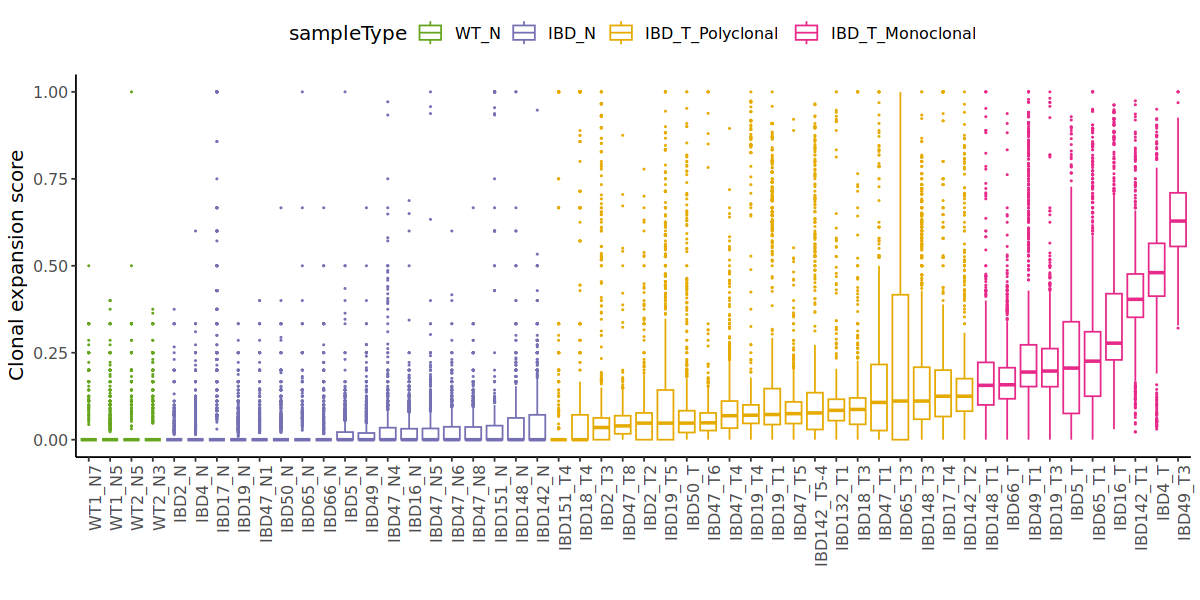

In [50]:
p1 <- ggplot(dt, aes(x=sampleType, y=dist,color=sampleType))+
  geom_boxplot(outlier.size=0.2)+#ggtitle()+
  labs(x="", y="Clonal expansion score")+theme_classic()+
  scale_y_continuous(breaks=c(0,0.25,0.5,0.75,1))+
  theme(text = element_text(size=12),plot.title = element_text(hjust = 0.5, size = 12),
        axis.text.x = element_text(angle = 30, vjust = 1, hjust=1),legend.position="none")+
  stat_compare_means(comparisons = my_comparisons)+
  scale_color_manual(values = cols)
p2 <- ggplot(dt, aes(x=sample, y=dist,color=sampleType))+
  geom_boxplot(outlier.size=0.2)+
  labs(x="", y="Clonal expansion score")+theme_classic()+
  theme(text = element_text(size=12),plot.title = element_text(hjust = 0.5, size = 12),
        axis.text.x = element_text(angle = 90, vjust = 1, hjust=1),legend.position="top")+
  guides(fill=guide_legend(title=NULL))+scale_color_manual(values = cols)
p2

In [51]:
pdf(file = paste0(OUTDIR,"3.1.clonal_expansion_score_genetically_only.pdf"), height = 8, width = 11)
ggarrange(p1, ncol=3, nrow=2)
ggarrange(p2, ncol=1,nrow=2)
dev.off()


png 
  2

In [53]:
dt[1:5,]

sampleType,sample,dist
<fct>,<fct>,<dbl>
WT_N,WT1_N5,0.0000000
WT_N,WT1_N5,0.0000000
WT_N,WT1_N5,0.0000000
WT_N,WT1_N5,0.0000000
WT_N,WT1_N5,0.1111111


## 4. Apc polyp pairwise distance

In [248]:
library(parallel)
library(reshape2)

INDIR = "/data2/kantian/LineageTracing/SMALT/0.Results/2.final_phy_re/"
setwd(INDIR)
OUTDIR = "/data2/kantian/LineageTracing/SMALT/0.Results/figures/"
sampleTypes = c("68","72")
samples = list(c("P1","P2","P3","P4","P5-1","P5-2","P5-3","P5-4","P5-5"),
               c("P1","P2","P4","P5","P6","P8","P9")
                  )
dt <- data.table()
for(my.type in 1:length(sampleTypes)){
    message("Calculating ", sampleTypes[my.type],"...")
    subs <- samples[[my.type]]
    compares <- rbind(as.data.frame(t(combn(subs,2))),data.frame(V1=subs, V2=subs))
    for(my.sample in 1:nrow(compares)){
        # message("\tCalculating ", compares$V1[my.sample], compares$V2[my.sample],"...")
        x <- read.delim(paste0(INDIR,sampleTypes[my.type],"_",compares$V1[my.sample],"_filtered_re.phy"),header = F, sep = " ",
                    colClasses=c("character","character"),skip = 2,
                    col.names = c("cellID","bi"))
        y <- read.delim(paste0(INDIR,sampleTypes[my.type],"_",compares$V2[my.sample],"_filtered_re.phy"),header = F, sep = " ",
                    colClasses=c("character","character"),skip = 2,
                    col.names = c("cellID","bi"))
        if(nrow(x)<1000){xcells <- sample(x$cellID, 1000, replace=TRUE)}else{xcells <- sample(x$cellID, 1000, replace=FALSE)}
        if(nrow(y)<1000){ycells <- sample(y$cellID, 1000, replace=TRUE)}else{ycells <- sample(y$cellID, 1000, replace=FALSE)}
        new <- mclapply(as.list(1:1000),function(i){
            c1 <- strsplit(x[x$cellID == xcells[i],]$bi,"")[[1]]
            c2 <- strsplit(y[y$cellID == ycells[i],]$bi,"")[[1]]
            similarity <- 1-length(c1[c1 != c2])/length(unique(c(which(c1 =="1"),which(c2 =="1"))))
            data.table(similarity = similarity)
        }, mc.cores=100)
        new <- rbindlist(new)
        new[, mouse:= paste0("Apc",sampleTypes[my.type])]
        new[, sample1 := compares$V1[my.sample]]
        new[, sample2 := compares$V2[my.sample]]
        dt <- rbind(dt, new)
    }
}
dt[, sample1 := gsub("P","P", sample1)]
dt[, sample2 := gsub("P","P", sample2)]
dt[1:3,]

Calculating 68...

Calculating 72...



similarity,mouse,sample1,sample2
<dbl>,<chr>,<chr>,<chr>
0,Apc68,P1,P2
0,Apc68,P1,P2
0,Apc68,P1,P2


png 
  2

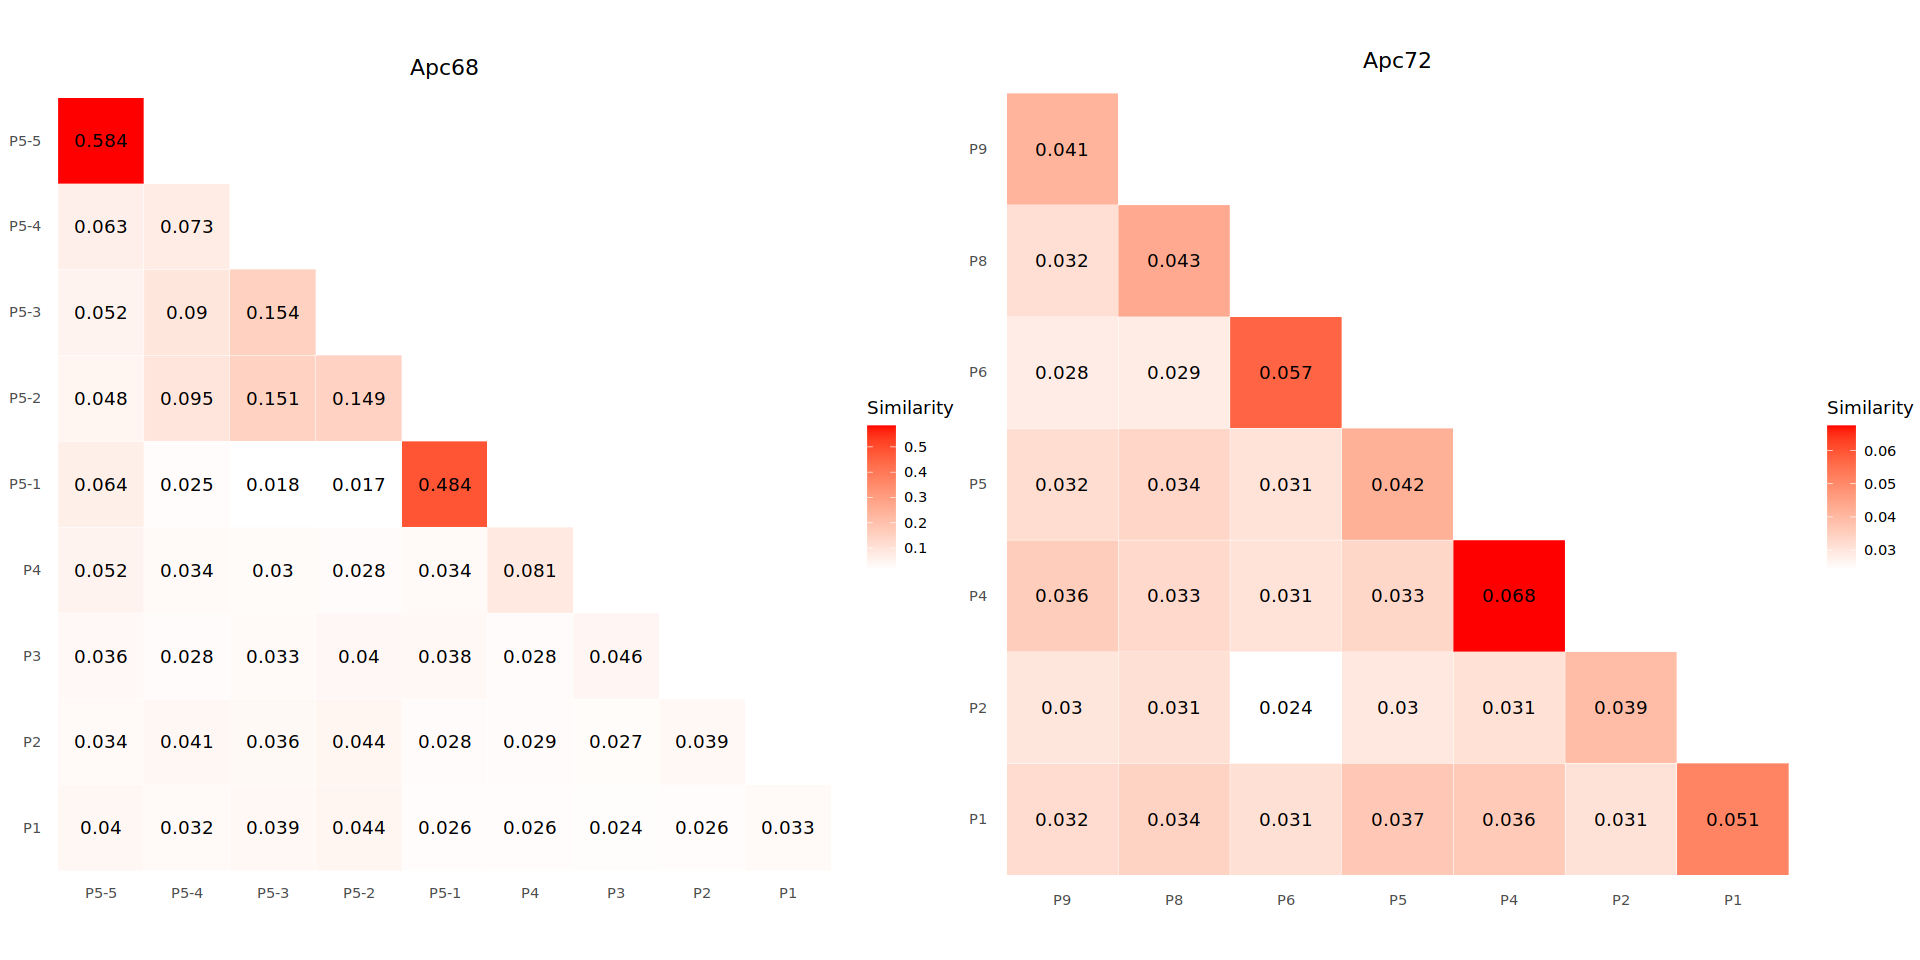

In [251]:
##-----------------------------------------------------------------
temp <- dt[, mean(similarity), by =c("mouse","sample1","sample2")]
temp <- temp[mouse =="Apc68"]
# temp$sample1 <- factor(temp$sample1, levels=rev(c("P5","P4","P3","P2","P1")))
temp$sample2 <- factor(temp$sample2, levels=c("P5-5","P5-4","P5-3","P5-2","P5-1","P4","P3","P2","P1"))
colnames(temp)[4] <- "Similarity"
p1 <- ggplot(temp,aes(sample2, sample1, fill=Similarity))+geom_tile(color="white")+
geom_text(aes(label=round(Similarity,3)))+theme_minimal()+
scale_fill_gradient(low="white",high="red", na.value="white")+coord_fixed()+
xlab("")+ylab("")+ggtitle("Apc68")+
theme(axis.title.x=element_blank(),
     axis.title.y=element_blank(),
     panel.grid.major=element_blank(),
     panel.border=element_blank(),
     axis.ticks=element_blank(),
     plot.title=element_text(hjust=0.5))
##-----------------------------------------------------------------
##-----------------------------------------------------------------
temp <- dt[, mean(similarity), by =c("mouse","sample1","sample2")]
temp <- temp[mouse =="Apc72"]
temp$sample2 <- factor(temp$sample2, levels=c("P9","P8","P6","P5","P4","P2","P1"))
colnames(temp)[4] <- "Similarity"
p2 <- ggplot(temp,aes(sample2, sample1, fill=Similarity))+geom_tile(color="white")+
geom_text(aes(label=round(Similarity,3)))+theme_minimal()+
scale_fill_gradient(low="white",high="red", na.value="white")+coord_fixed()+
xlab("")+ylab("")+ggtitle("Apc72")+
theme(axis.title.x=element_blank(),
     axis.title.y=element_blank(),
     panel.grid.major=element_blank(),
     panel.border=element_blank(),
     axis.ticks=element_blank(),
     plot.title=element_text(hjust=0.5))
options(repr.plot.width = 16, repr.plot.height = 8)
ggarrange(p1,p2, ncol=2)
pdf(file = paste0(OUTDIR,"4.2.polyp_pairwise_distance_68P5split.pdf"), height = 8, width = 16)
ggarrange(p1,p2, ncol=2,nrow=1)
dev.off()
